In this portion of the code, we import our datasets and join test and train together for some preprocessing. We convert categorical variables into dummy variables. The cleaned datasets are labeled X_dummy, y_dummy. We then split X_dummy back into train_dummy and test_dummy. y is raveled (turned into a one-dimensional array) due to model demands.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

simp = SimpleImputer(strategy='most_frequent')
medi = SimpleImputer(strategy='median')

train_X = pd.read_csv('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/X.csv')
y = pd.read_csv('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/y.csv')
test_X = pd.read_csv('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/test.csv')

X_full = pd.concat([train_X, test_X])
X = X_full[X_full.columns[X_full.isnull().mean() < 0.99]]

nan_cat = X.iloc[:, :83]
nan_num = X.iloc[:,83:]
nnum = pd.DataFrame(medi.fit_transform(nan_num))
ncat = pd.DataFrame(simp.fit_transform(nan_cat))

#this is the data for xgboost - the algorithm takes care of null values on its own
X_dummy_nans = pd.get_dummies(data=X)
y_dummy = pd.get_dummies(data=y, drop_first=True)

train_dummy = X_dummy_nans.iloc[:10622, :]
test_dummy = X_dummy_nans.iloc[10622:, :]

y_array = y_dummy.to_numpy()
y_raveled = y_array.ravel()

X_train_nans,  X_test_nans, y_train_nans, y_test_nans = train_test_split(train_dummy, y_raveled, test_size=0.33, random_state=7)

#and this is the data for random forest - this algorithm needs to have the nans preprocessed

X_fill = pd.concat([ncat, nnum], axis = 1)
X_dummy_fill = pd.get_dummies(data=X_fill)
train_dummy_fill = X_dummy_fill.iloc[:10622, :]
test_dummy_fill = X_dummy_fill.iloc[10622:, :]

X_train, X_test, y_train, y_test = train_test_split(train_dummy_fill, y_raveled, test_size=0.33, random_state=7)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,4,5,7,8,9,10,11,13,14,15,17,18,19,20,23,24,26,27,28,33,34,35,36,37,38,39,40,44,45,46,47,48,49,64,70,71,78,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **XGBOOST**

Crossvalidation to tune XGBoost hyperparameters

In [7]:
import xgboost as xgb

train_dmatrix = xgb.DMatrix(data=train_dummy, label=y_dummy)

params = {'objective': 'binary:logistic','booster': 'gbtree', 'colsample_bytree': 0.8,'learning_rate': 0.1,
                'max_depth': 8, 'gamma':0.2, 'subsample':0.8, 'reg_alpha':0.0001, 'min_child_weight':6}

my_cv = xgb.cv(dtrain=train_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics='auc', as_pandas=True, seed=7)

print(my_cv)

print((my_cv['test-auc-mean']).tail(1))

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.735392       0.009866       0.692532      0.014703
1         0.786119       0.013149       0.739739      0.016095
2         0.814470       0.003431       0.764406      0.016102
3         0.825346       0.002728       0.778056      0.016602
4         0.830039       0.004004       0.783494      0.014728
5         0.834653       0.006502       0.786811      0.011527
6         0.838912       0.005245       0.787838      0.013170
7         0.841602       0.006353       0.789497      0.014158
8         0.845346       0.006039       0.792847      0.012146
9         0.848640       0.005535       0.795412      0.010442
10        0.851533       0.005071       0.797738      0.010055
11        0.853761       0.005052       0.799337      0.009788
12        0.857544       0.004877       0.801494      0.009841
13        0.859796       0.004223       0.802393      0.010576
14        0.862734       0.004000       0.804735      0

In [8]:
max_xgb = xgb.XGBClassifier(objective= 'binary:logistic',booster='gbtree', colsample_bytree=0.8,
                           learning_rate=0.1, max_depth=8, gamma=0.2, subsample=0.8, reg_alpha=0.0001,
                           min_child_weight=6)
max_xgb.fit(X_train_nans, y_train_nans)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0001, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

# **Random Forest**

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
!pip install shap
import shap

max_forest = RandomForestClassifier(n_estimators=200, max_depth = 9, min_samples_split = 300,random_state=7)

scores = cross_val_score(max_forest, train_dummy_fill, y_raveled, cv=5)
print(scores)

max_forest.fit(X_train, y_train)


     |████████████████████████████████| 276kB 8.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394131 sha256=ffcf6dafff39e0415dba70a63fb8feeb723cf29ec2b660a40082793f4d2c38eb
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
[0.65364706 0.66117647 0.6492467  0.61676083 0.61770245]


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

here we calculate auc scores for xgboost and random forest

In [10]:
from sklearn.metrics import roc_auc_score
y_test_rf = max_forest.predict(X_test)
y_test_xgb = max_xgb.predict(X_test_nans)

print(roc_auc_score(y_test, y_test_rf))
print(roc_auc_score(y_test_nans, y_test_xgb))

0.5731587831815328
0.706041582675805


* Generate AUC curve for the combined xgboost and random forest scores 

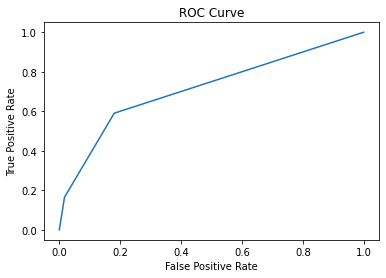

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_test_combo = (y_test_xgb + y_test_rf)/2.0

fpr, tpr, thresholds = roc_curve(y_test, y_test_combo)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/roc-auc-curve.png')
plt.show()

Combine xgboost and random forest predictions together!

In [12]:
#xgboost
max_xgb.fit(train_dummy, y_raveled)
y_array_xgb = max_xgb.predict_proba(test_dummy)
y_pred_xgb = pd.DataFrame(data=y_array_xgb)

#random forest
max_forest.fit(train_dummy_fill,y_raveled)
y_array_f = max_forest.predict_proba(test_dummy_fill)
y_pred_f = pd.DataFrame(data=y_array_f)

y_preds = pd.concat([y_pred_xgb[1], y_pred_f[1]], axis=1)
print(y_preds)
y_pred_combo = y_preds.mean(axis=1)
y_pred_combo.to_csv('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/y_pred_combo.csv')


             1         1
0     0.106704  0.374355
1     0.292221  0.387609
2     0.292221  0.387609
3     0.292221  0.387609
4     0.235621  0.455298
...        ...       ...
1118  0.450366  0.437021
1119  0.409146  0.468582
1120  0.332619  0.465164
1121  0.622183  0.451644
1122  0.495856  0.436427

[1123 rows x 2 columns]


Now we calculate SHAP values. Because I made use of two models and averaged their predictions, I will calculate the SHAP values for each model separately.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


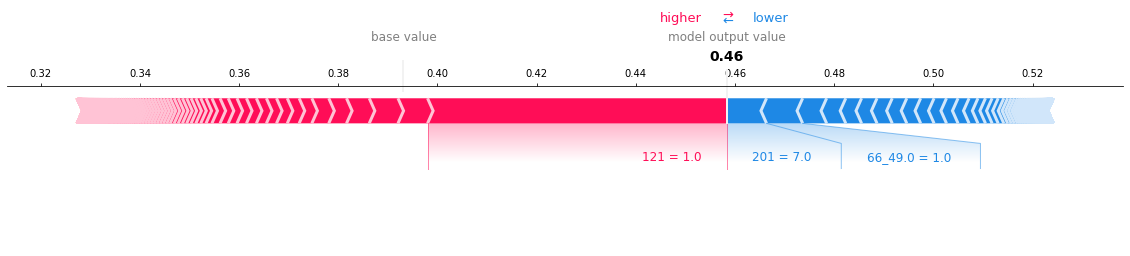

In [13]:
explainer = shap.TreeExplainer(max_forest)

data_for_pred = test_dummy_fill.iloc[5, :]
shap_values = explainer.shap_values(data_for_pred)
shap.initjs()
new_plot = shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_pred, show=False, matplotlib=True)
f = plt.gcf()
f.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/shap_5.png')


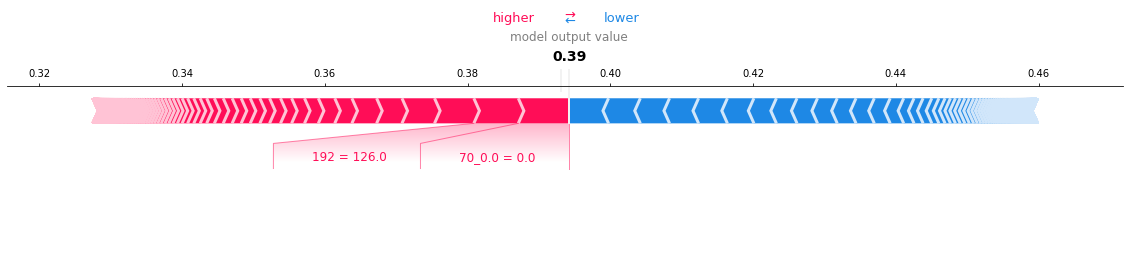

In [14]:
data_for_pred50 = test_dummy_fill.iloc[50, :]
shap_values50 = explainer.shap_values(data_for_pred50)
shap.initjs()
new_plot50 = shap.force_plot(explainer.expected_value[1], shap_values50[1], data_for_pred50, show=False, matplotlib=True)
f50 = plt.gcf()
f50.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/shap-50.png')

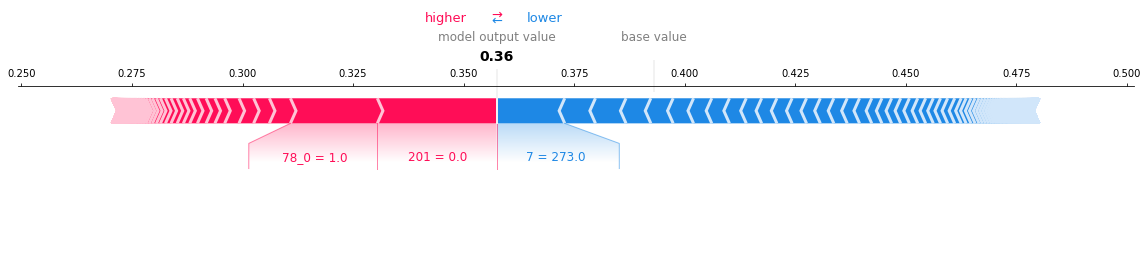

In [15]:
data_for_pred500 = test_dummy_fill.iloc[500, :]
shap_values500 = explainer.shap_values(data_for_pred500)
shap.initjs()
new_plot500 = shap.force_plot(explainer.expected_value[1], shap_values500[1], data_for_pred500, show=False, matplotlib=True)
f500 = plt.gcf()
f500.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/shap-500.png')

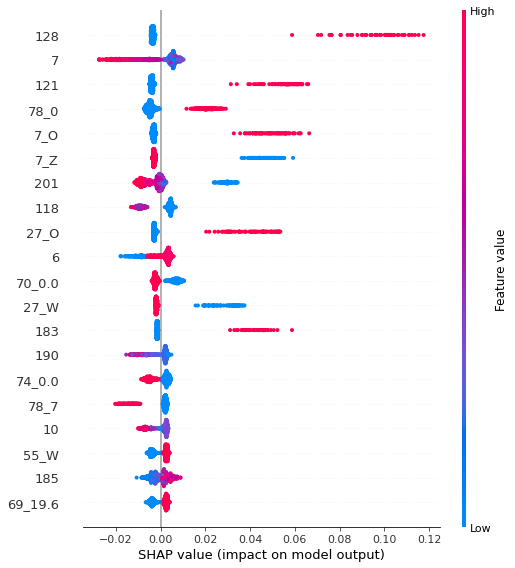

In [16]:
all_shap_values = explainer.shap_values(test_dummy_fill)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(all_shap_values[1], test_dummy_fill, show=False)
all_f = plt.gcf()
all_f.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/sum_plt.png')

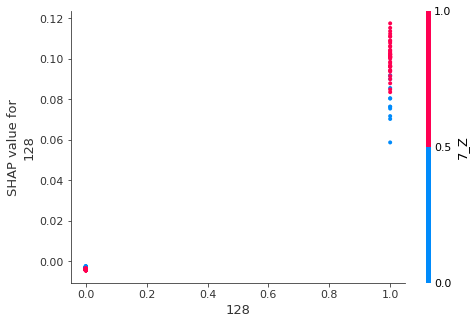

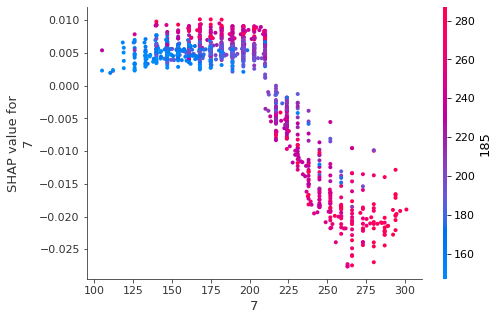

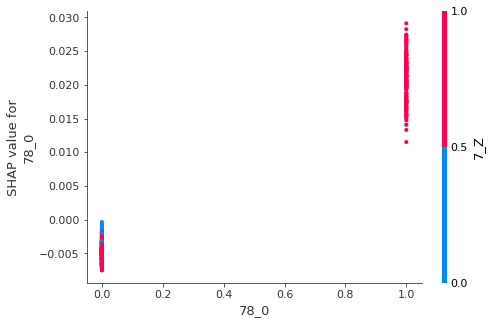

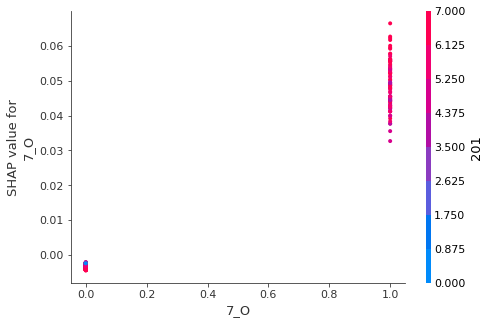

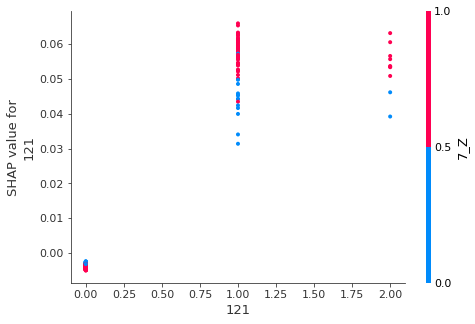

In [18]:
shap.dependence_plot(128, all_shap_values[1], test_dummy_fill, show=False)
f_128 = plt.gcf()
f_128.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/128_plt.png')

shap.dependence_plot(7, all_shap_values[1], test_dummy_fill, show=False)
f_7 = plt.gcf()
f_7.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/7_plt.png')

shap.dependence_plot('78_0', all_shap_values[1], test_dummy_fill, show=False)
f_78_O = plt.gcf()
f_78_O.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/78_O_plt.png')

shap.dependence_plot('7_O', all_shap_values[1], test_dummy_fill, show=False)
f_7_O = plt.gcf()
f_7_O.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/7_O_plt.png')

shap.dependence_plot(121, all_shap_values[1], test_dummy_fill, show=False)
f_121 = plt.gcf()
f_121.savefig('/content/drive/My Drive/Ben Gurion PhD/AI course/HW2/121_plt.png')
